In [1]:
# data analysis
import pandas as pd
# WaveForm DataBase
import wfdb
# visualization
import matplotlib.pyplot as plt
# numerical analysis
import numpy as np
# signal processing
from scipy import signal

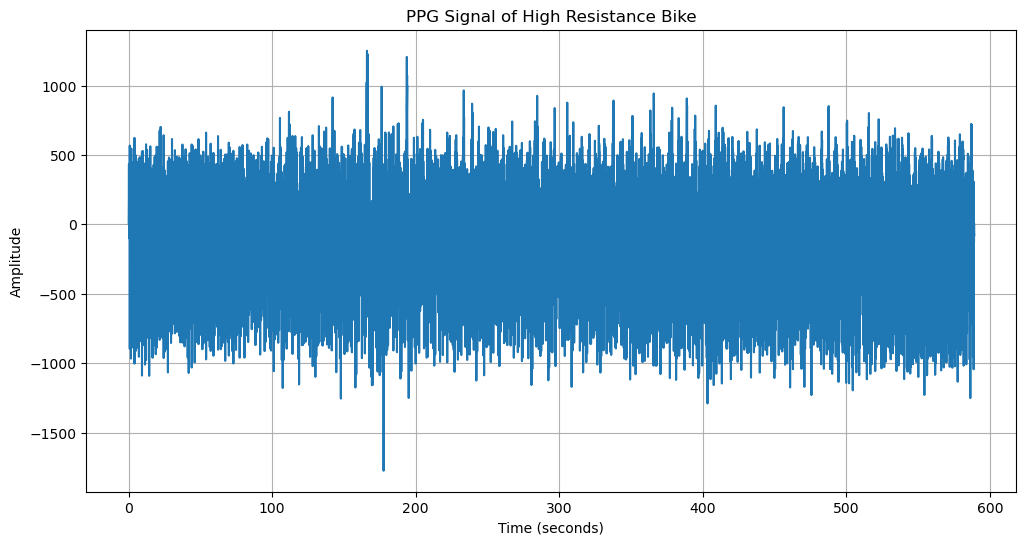

In [2]:
# data
record_name = "wrist_ppg_during_exercise/s1_high_resistance_bike"
record = wfdb.rdrecord(record_name)
print(record)

# Get the PPG signal data
ppg_signal = record.p_signal.T[0]  # Assuming PPG is the first channel

# Create a time array
time = np.arange(len(ppg_signal)) / record.fs  # record.fs is the sampling frequency

# ... existing code ...

# Plot the PPG signal
plt.figure(figsize=(12, 6))
plt.plot(time, ppg_signal)
plt.title('PPG Signal of High Resistance Bike')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.grid(True)

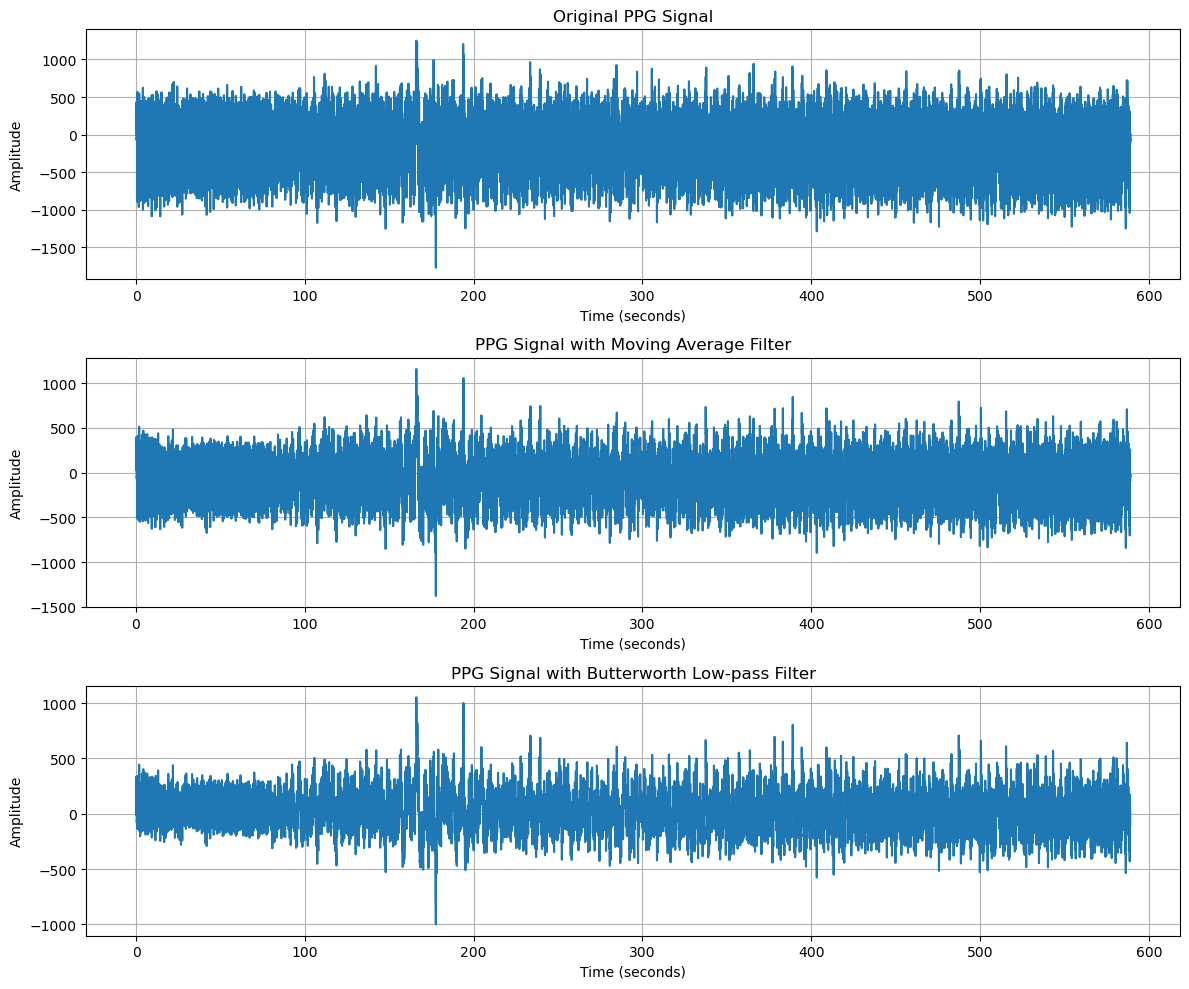

In [3]:

# Get the PPG signal data
ppg_signal = record.p_signal.T[0]  # Assuming PPG is the first channel

# Create a time array
time = np.arange(len(ppg_signal)) / record.fs  # record.fs is the sampling frequency

# Apply Moving Average filter
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size), 'valid') / window_size

# Apply Butterworth filter
def butterworth_lowpass(data, cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    return signal.filtfilt(b, a, data)

# Apply filters
window_size = 10  # Adjust this value as needed
ppg_ma = moving_average(ppg_signal, window_size)

cutoff = 5  # Cutoff frequency in Hz, adjust as needed
ppg_butterworth = butterworth_lowpass(ppg_signal, cutoff, record.fs)

# Plot the original and filtered signals
plt.figure(figsize=(12, 10))

plt.subplot(3, 1, 1)
plt.plot(time, ppg_signal)
plt.title('Original PPG Signal')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(time[window_size-1:], ppg_ma)
plt.title('PPG Signal with Moving Average Filter')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(time, ppg_butterworth)
plt.title('PPG Signal with Butterworth Low-pass Filter')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.grid(True)

plt.tight_layout()
plt.show()

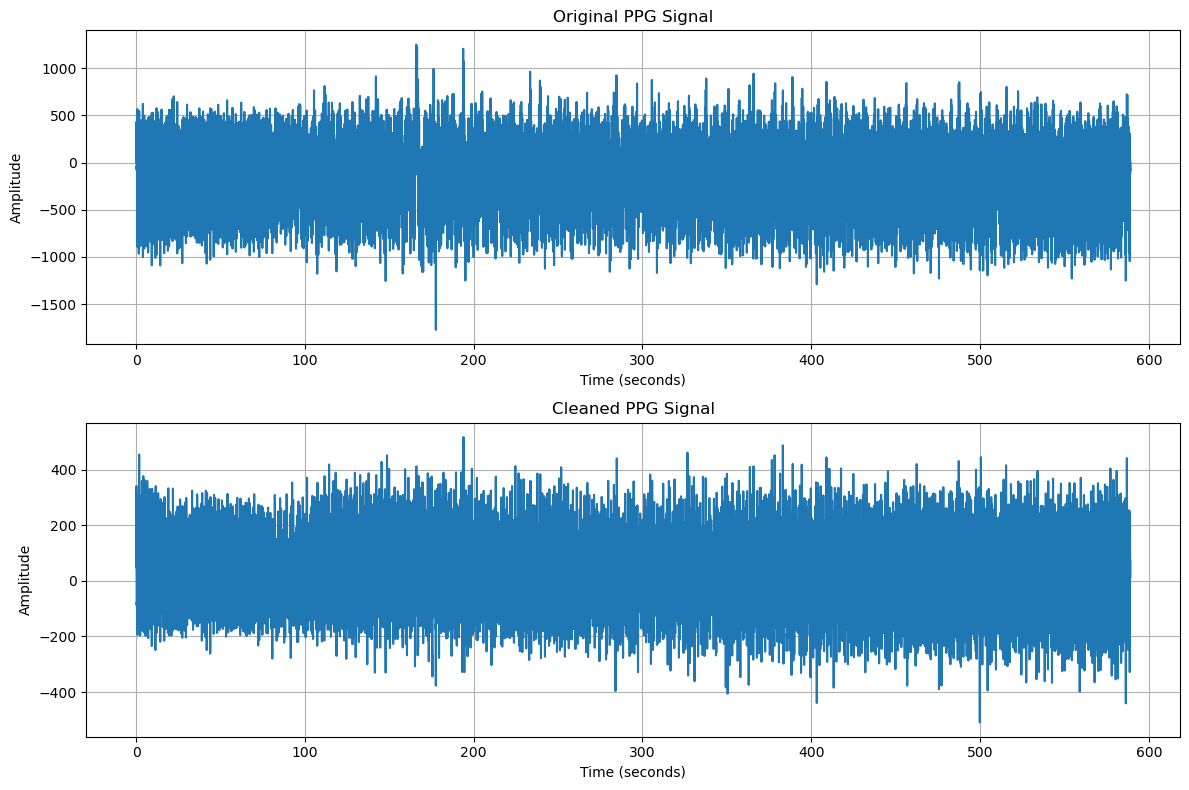

In [4]:
from scipy import signal
import pywt

def denoise_ppg(ppg_signal, fs):
    # 1. Wavelet denoising
    wavelet = 'db4'
    level = 5
    coeffs = pywt.wavedec(ppg_signal, wavelet, level=level)
    
    # Threshold calculation
    sigma = np.median(np.abs(coeffs[-1])) / 0.6745
    threshold = sigma * np.sqrt(2 * np.log(len(ppg_signal)))
    
    # Apply soft thresholding
    coeffs = [pywt.threshold(c, threshold, mode='soft') for c in coeffs]
    denoised_signal = pywt.waverec(coeffs, wavelet)

    # 2. Bandpass filter
    lowcut = 0.5  # Hz
    highcut = 8.0  # Hz
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(4, [low, high], btype='band')
    filtered_signal = signal.filtfilt(b, a, denoised_signal)

    # 3. Savitzky-Golay filter for smoothing
    window_length = 51  # Must be odd
    polyorder = 3
    smoothed_signal = signal.savgol_filter(filtered_signal, window_length, polyorder)

    return smoothed_signal

# Apply the noise reduction algorithm
cleaned_ppg = denoise_ppg(ppg_signal, record.fs)
cleaned_ppg = cleaned_ppg[:len(time)]

# Plot the original and cleaned signals
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(time, ppg_signal)
plt.title('Original PPG Signal')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(time, cleaned_ppg)
plt.title('Cleaned PPG Signal')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.grid(True)

plt.tight_layout()
plt.show()

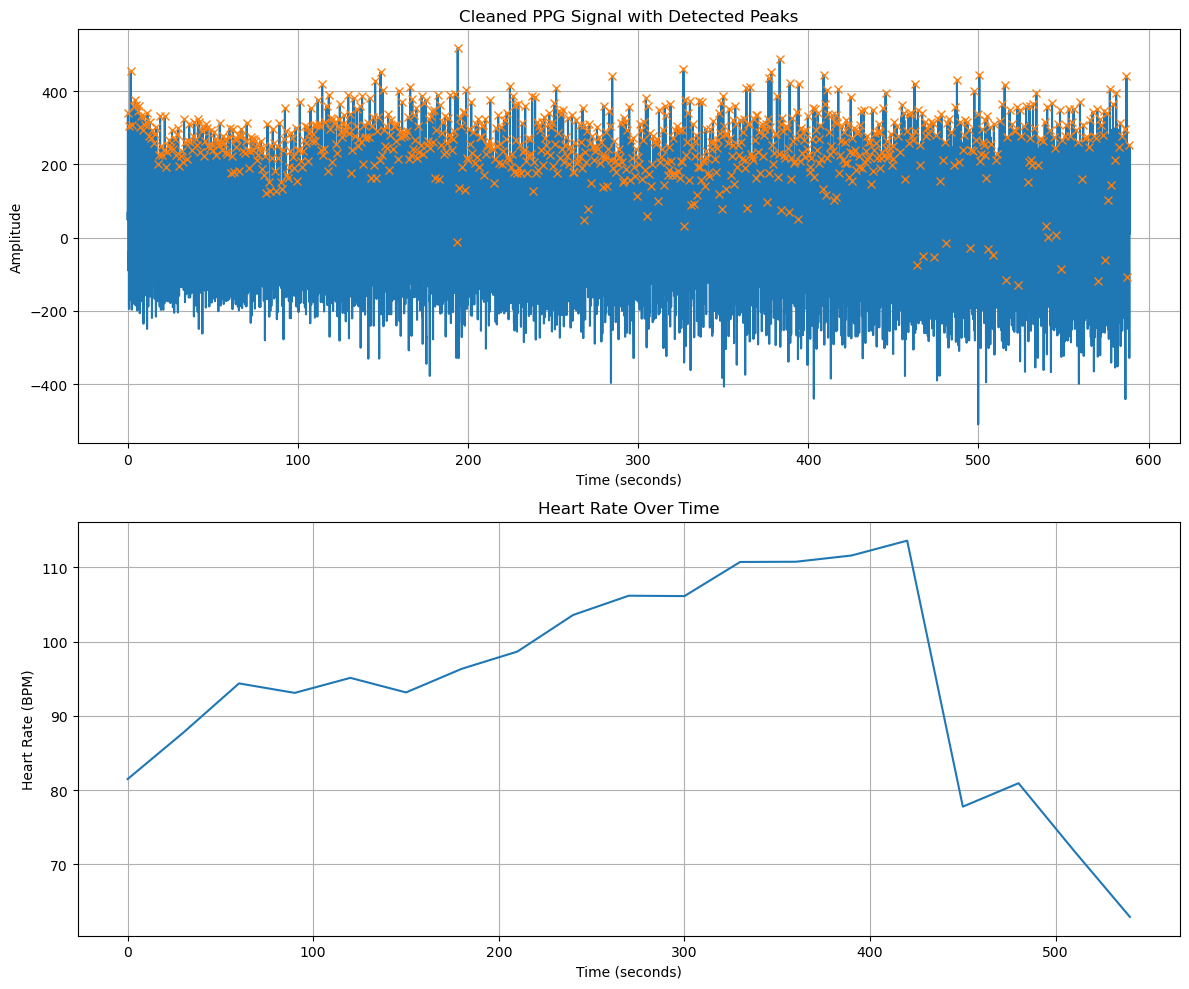

Average Heart Rate: 96.28 BPM


In [5]:
from scipy.signal import find_peaks

def detect_heart_rate(ppg_signal, fs, time_window=30):
    # Function to detect heart rate from PPG signal
    
    # Find peaks in the signal
    peaks, _ = find_peaks(ppg_signal, distance=fs*0.5)  # Minimum distance between peaks (0.5 seconds)
    
    # Calculate intervals between peaks (in seconds)
    intervals = np.diff(peaks) / fs
    
    # Calculate instantaneous heart rates
    inst_heart_rates = 60 / intervals  # 60 seconds / interval
    
    # Filter out physiologically impossible heart rates
    valid_rates = inst_heart_rates[(inst_heart_rates >= 40) & (inst_heart_rates <= 200)]
    
    # Calculate average heart rate
    avg_heart_rate = np.mean(valid_rates)
    
    # Calculate heart rate over time using a sliding window
    window_samples = int(time_window * fs)
    heart_rates_over_time = []
    times_over_time = []
    
    for i in range(0, len(ppg_signal) - window_samples, window_samples):
        window = ppg_signal[i:i+window_samples]
        window_peaks, _ = find_peaks(window, distance=fs*0.5)
        if len(window_peaks) > 1:
            window_intervals = np.diff(window_peaks) / fs
            window_rates = 60 / window_intervals
            valid_window_rates = window_rates[(window_rates >= 40) & (window_rates <= 200)]
            if len(valid_window_rates) > 0:
                heart_rates_over_time.append(np.mean(valid_window_rates))
                times_over_time.append(i / fs)
    
    return avg_heart_rate, heart_rates_over_time, times_over_time, peaks

# Detect heart rate
avg_hr, hrs_over_time, times_over_time, peaks = detect_heart_rate(cleaned_ppg, record.fs)

# Plot results
plt.figure(figsize=(12, 10))

# Plot cleaned PPG signal with detected peaks
plt.subplot(2, 1, 1)
plt.plot(time, cleaned_ppg)
plt.plot(time[peaks], cleaned_ppg[peaks], "x")
plt.title('Cleaned PPG Signal with Detected Peaks')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.grid(True)

# Plot heart rate over time
plt.subplot(2, 1, 2)
plt.plot(times_over_time, hrs_over_time)
plt.title('Heart Rate Over Time')
plt.xlabel('Time (seconds)')
plt.ylabel('Heart Rate (BPM)')
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"Average Heart Rate: {avg_hr:.2f} BPM")


In [6]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length + 1):
        sequences.append(data[i:i+seq_length])
    return np.array(sequences)

def detect_anomalies(ppg_signal, fs, threshold=0.1):
    # Normalize the data
    scaler = MinMaxScaler()
    normalized_signal = scaler.fit_transform(ppg_signal.reshape(-1, 1)).flatten()

    # Create sequences
    seq_length = 100  # Adjust based on your signal characteristics
    sequences = create_sequences(normalized_signal, seq_length)

    # Reshape sequences for LSTM input
    sequences = sequences.reshape(-1, seq_length, 1)

    # Split the data
    X_train, X_test = train_test_split(sequences, test_size=0.2, random_state=42)

    # Build the autoencoder model
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(seq_length, 1)),
        tf.keras.layers.LSTM(64, activation='relu', return_sequences=True),
        tf.keras.layers.LSTM(32, activation='relu', return_sequences=False),
        tf.keras.layers.RepeatVector(seq_length),
        tf.keras.layers.LSTM(32, activation='relu', return_sequences=True),
        tf.keras.layers.LSTM(64, activation='relu', return_sequences=True),
        tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1))
    ])

    model.compile(optimizer='adam', loss='mse')

    # Train the model
    model.fit(X_train, X_train, epochs=1, batch_size=2048, validation_split=0.1, verbose=1)

    # Predict on the entire dataset
    reconstructed = model.predict(sequences)

    # Reshape reconstructed to match sequences
    reconstructed = reconstructed.reshape(-1, seq_length)

    # Calculate MSE
    mse = np.mean(np.power(sequences.reshape(-1, seq_length) - reconstructed, 2), axis=1)

    # Detect anomalies
    anomalies = mse > threshold

    return anomalies, mse, seq_length

# Detect anomalies in the cleaned PPG signal
anomalies, reconstruction_error, seq_length = detect_anomalies(cleaned_ppg, record.fs)

# Adjust time array for plotting anomalies
adjusted_time = time[seq_length-1:]

2024-10-25 15:43:01.414961: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


53/53 ━━━━━━━━━━━━━━━━━━━━ 242s 4s/step - loss: 0.1620 - val_loss: 0.0281
4709/4709 ━━━━━━━━━━━━━━━━━━━━ 143s 30ms/step


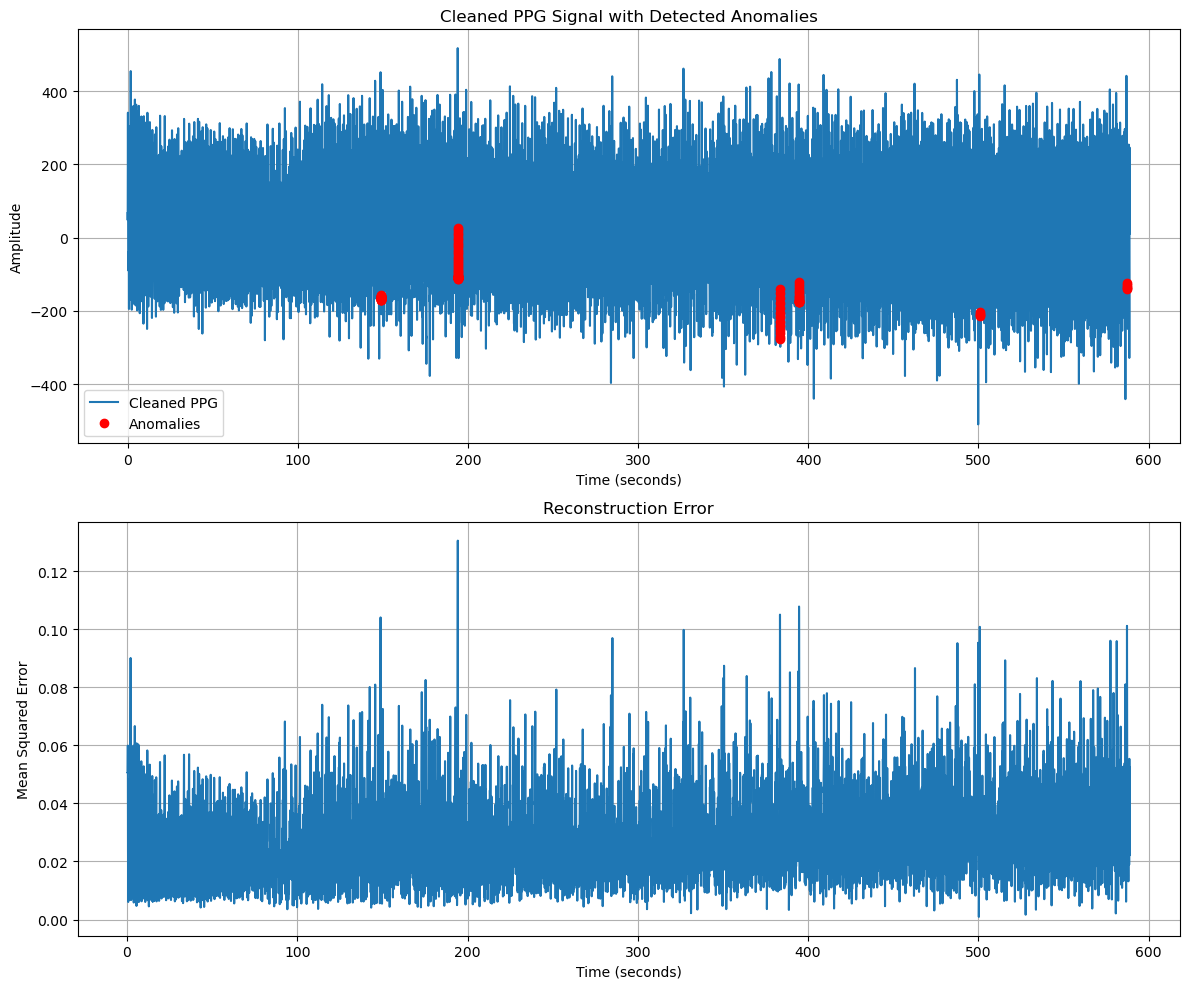

Number of anomalies detected: 96
Percentage of signal flagged as anomalous: 0.06%


In [7]:
# Plot results
plt.figure(figsize=(12, 10))

# Plot cleaned PPG signal with anomalies highlighted
plt.subplot(2, 1, 1)
plt.plot(time, cleaned_ppg, label='Cleaned PPG')
plt.plot(adjusted_time[anomalies], cleaned_ppg[seq_length-1:][anomalies], 'ro', label='Anomalies')
plt.title('Cleaned PPG Signal with Detected Anomalies')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

# Plot reconstruction error
plt.subplot(2, 1, 2)
plt.plot(adjusted_time, reconstruction_error)
plt.title('Reconstruction Error')
plt.xlabel('Time (seconds)')
plt.ylabel('Mean Squared Error')
plt.grid(True)

plt.tight_layout()
plt.show()

# Print summary of anomalies
print(f"Number of anomalies detected: {np.sum(anomalies)}")
print(f"Percentage of signal flagged as anomalous: {np.sum(anomalies) / len(anomalies) * 100:.2f}%")
